In [63]:
import numpy as np
import pandas as pd
import scipy as sc
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split
import matplotlib.pyplot as plt

count      5000.00000
mean       9189.71360
std       19510.23063
min           1.00000
25%        1191.00000
50%        2887.50000
75%        8278.50000
max      378795.00000
Name: Words, dtype: float64


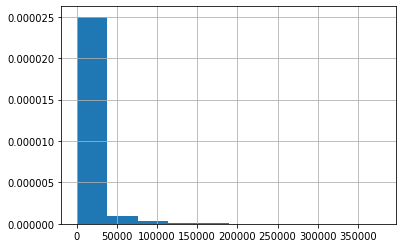

In [64]:
#Analyse unidimensionnelle Bastien LEVEILLE
#Le nombre de mots
HPData = pd.read_csv(r"finalHPData.csv")
print(HPData['Words'].describe())
HPData["Words"].hist(density = True)        

(0.7307790227282863, 0.0)


[]

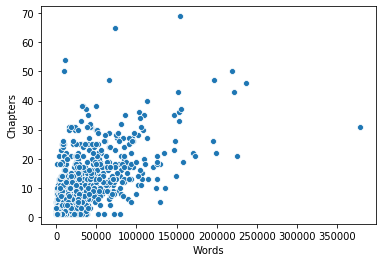

In [66]:
#Analyse bidimensionnelle Gaël LODE
#Le nombre de mots par rapport au nombre de Chapitre
x= HPData['Words']
y=HPData['Chapters']
sns.scatterplot(x,y)
print(sc.stats.pearsonr(x,y))
plt.plot()